In [1]:
!pip install -U sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch.nn.functional as F

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles

        self.max_length = 100
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)
        
        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        # mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
        
        # Pad input
        if len(indices) < self.max_length:
        
            num_pad = self.max_length - len(indices)
            
            indices = F.pad(indices, (0, num_pad), value=-1)
            
        return indices, len(indices) - 1
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str, number_of_inputs: float):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age),
            number_of_inputs  # NEW
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx = line_items
            
            customer_id_idx = int(customer_id_idx)
            fashion_news_frequency_idx = int(fashion_news_frequency_idx)
            club_member_status_idx = int(club_member_status_idx)
            postal_code_idx = int(club_member_status_idx)

            number_of_inputs = len(article_id_idx_last10.split(',')) / 100 # NEW
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age, number_of_inputs)
            
            seq, end_seq_idx = self.mean_historical_purchases_embedding(article_id_idx_last10)
            # mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)            

            yield customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, seq, end_seq_idx, numeric_features_tensor, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt_with_counts_and_age_extended_100_hist_with_more_cust_feat.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(48726, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt_with_counts_and_age_extended_100_hist_with_more_cust_feat.csv')
print(customers.shape)
customers.head()

(52787, 11)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,ACTIVE,MISSING,0.45,4ca377c955c160866d5662b33aa1af44d54d4342fb8bfa...,0,0,0,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,ACTIVE,Regularly,0.44,930b19ae7db8abb5a27f4da10217755a7305b4c452f5e0...,1,1,0,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,ACTIVE,MISSING,0.21,4211d6bf468de190b2f135feed96ed94b1c47f1d68991c...,2,0,0,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,ACTIVE,Regularly,0.33,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...,3,1,0,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,ACTIVE,MISSING,0.21,2c29ae653a9282cce4151bd87643c907644e09541abc28...,4,0,0,4


### Create article EmbeddingBag

In [10]:
model = SentenceTransformer('all-distilroberta-v1')

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [12]:
model.encode(article_descriptions[0]).shape

(768,)

In [13]:
embeddings = model.encode(article_descriptions)

In [14]:
embeddings = torch.tensor(embeddings)

In [15]:
embeddings.shape

torch.Size([48726, 768])

In [16]:
ARTICLE_EMBEDDING = nn.Embedding.from_pretrained(embeddings=embeddings, freeze=True)

In [17]:
ARTICLE_EMBEDDING.to(device)

Embedding(48726, 768)

### Model

In [18]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)   
        self.postal_code_embeddings = nn.Embedding(num_embeddings=46025, embedding_dim=384)
        self.fashion_news_frequency_embeddings = nn.Embedding(num_embeddings=3, embedding_dim=32)
        self.club_member_status_embeddings = nn.Embedding(num_embeddings=4, embedding_dim=32)
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.postal_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.fashion_news_frequency_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.club_member_status_embeddings.weight)
        
        # LSTM
        self.lstm = torch.nn.LSTM(input_size=768, hidden_size=768, batch_first=True)

        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+768+4+1+384+32*2, out_features=2048)
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        # self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx,
        fashion_news_frequency_idx, 
        club_member_status_idx, 
        postal_code_idx,
        seq, 
        end_seq_idx, 
        numeric_features_tensor
    ):

        user_emb = self.user_embeddings(customer_id_idx)
        pc_emb = self.postal_code_embeddings(postal_code_idx)
        fash_news_emb = self.fashion_news_frequency_embeddings(fashion_news_frequency_idx)
        mem_status_emb = self.club_member_status_embeddings(club_member_status_idx)
        
        article_emb = ARTICLE_EMBEDDING(seq)
        all_h_t, _ = self.lstm(article_emb)
        h_t = all_h_t[:, -1, :]

        print(h_t.shape)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                pc_emb,
                fash_news_emb,
                mem_status_emb,
                torch.squeeze(h_t),
                numeric_features_tensor
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        # x = self.dropout(x)

        x = self.fc_3(x)

        return x

In [19]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [20]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(52787, 384)
  (postal_code_embeddings): Embedding(46025, 384)
  (fashion_news_frequency_embeddings): Embedding(3, 32)
  (club_member_status_embeddings): Embedding(4, 32)
  (lstm): LSTM(768, 768, batch_first=True)
  (fc_1): Linear(in_features=1605, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=48726, bias=True)
  (relu): ReLU()
)

In [21]:
BATCH_SIZE = 1024

In [22]:
# lstm = torch.nn.LSTM(input_size=768, hidden_size=100, batch_first=True)

In [23]:
# output, (h_n, c_n) = lstm(article_emb)

# output.shape, h_n.shape, c_n.shape

output:

N, seq length, hidden

In [24]:
# output[:, 1, :].shape

In [22]:
total_training_examples = pd.read_csv('data/final_train_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

52.0

In [23]:
total_dev_examples = pd.read_csv('data/final_dev_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

10.0

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [25]:
MAX_EPOCHS = 200

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', article_emb_bag=None, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, seq, end_seq_idx, numeric_features_tensor, label = data
        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, seq, end_seq_idx, numeric_features_tensor, label = customer_id_idx.to(device), fashion_news_frequency_idx.to(device), club_member_status_idx.to(device), postal_code_idx.to(device), seq.to(device), end_seq_idx.to(device), numeric_features_tensor.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, seq, end_seq_idx, numeric_features_tensor)
                
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
    
    scheduler.step()

    if ((epoch + 1) % 200 == 0) | (epoch == 0):

        print(f"Learning rate: {scheduler.get_last_lr()}")

        # Compute train loss:
        
        total_train_loss = 0

        fashion_rec_v3.eval()
        
        train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', article_emb_bag=None, total_articles=len(articles_df))    
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
        
        with torch.no_grad():
            for data in tqdm(train_loader, total=total_batches):

                customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = data
                customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = customer_id_idx.to(device), fashion_news_frequency_idx.to(device), club_member_status_idx.to(device), postal_code_idx.to(device), inputs.to(device), label.to(device)

                y_pred = fashion_rec_v3(customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs)

                loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

                total_train_loss += loss.item()

            mean_train_loss = total_train_loss / total_training_examples
            print(f"Training loss: {mean_train_loss}")
            training_losses.append(mean_train_loss)
            
        # Compute dev loss:
        
        total_dev_loss = 0
        
        dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
        
        dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
        
        with torch.no_grad():
            for data in tqdm(dev_loader, total=total_dev_batches):

                customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = data
                customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = customer_id_idx.to(device), fashion_news_frequency_idx.to(device), club_member_status_idx.to(device), postal_code_idx.to(device), inputs.to(device), label.to(device)

                y_pred = fashion_rec_v3(customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs)

                loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

                total_dev_loss += loss.item()

            mean_dev_loss = total_train_loss / total_dev_examples
            print(f"Dev loss: {mean_dev_loss}")
            dev_losses.append(mean_dev_loss)
            
        fashion_rec_v3.train()

  2%|▏         | 1/52.0 [00:00<00:12,  4.12it/s]

torch.Size([1024, 768])


  2%|▏         | 1/52.0 [00:00<00:29,  1.71it/s]


RuntimeError: ignored

In [25]:
training_losses, dev_losses

([8.622836917855011, 0.9448104188638567],
 [44.48965813535456, 4.87476371621214])

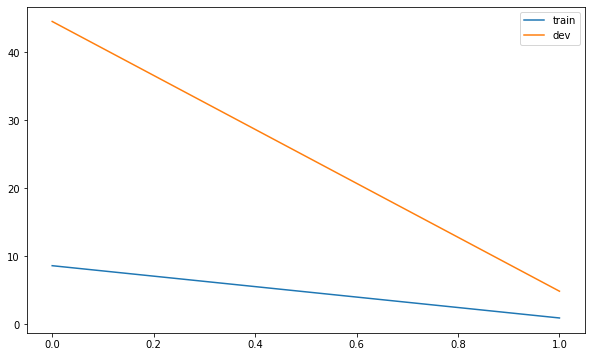

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [27]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = data
        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = customer_id_idx.to(device), fashion_news_frequency_idx.to(device), club_member_status_idx.to(device), postal_code_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs)
        
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 52/52.0 [00:15<00:00,  3.37it/s]


In [28]:
predictions = torch.concat(predictions)

In [29]:
predictions.shape

torch.Size([52787, 1000])

In [30]:
actuals = pd.read_csv('data/final_train_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

52787

In [31]:
mapk(actuals, predictions.tolist(), 12)

0.9988616727234265

🤯

In [32]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [33]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.9999986534860597

In [34]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [35]:
np.mean(np.array(number_of_positive_examples ) > 0)

1.0

Model is a strong top-1000 candidate generator:
- 99+% precision
- Can use all customers in training set since each has at least 1 positive example 

This could then facilitate a 2-stage approach like YouTube

#### Dev

In [36]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = data
        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = customer_id_idx.to(device), fashion_news_frequency_idx.to(device), club_member_status_idx.to(device), postal_code_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs)
        
        # predictions.append(y_pred.topk(12, dim=1).indices)
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 10/10.0 [00:03<00:00,  2.78it/s]


In [37]:
predictions = torch.concat(predictions)

In [38]:
predictions.shape

torch.Size([10231, 1000])

In [39]:
actuals = pd.read_csv('data/final_dev_set_with_counts_and_age_extended_100_hist.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

10231

In [40]:
mapk(actuals, predictions.tolist(), 12)

0.06543286769378921

In [41]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [42]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.35012874995600196

In [43]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [44]:
np.mean(np.array(number_of_positive_examples) > 0)

0.5669045059134005

In a 2-step approach this is the metric we would care about most. 35% is similar to what was achieved with simple heuristic candidate generators but here we also acheive strong MAP!

In [45]:
actuals_perfect_order = [[i for i in act if i in pred] for act, pred in zip(actuals, predictions.tolist())]

In [46]:
mapk(actuals_perfect_order, predictions.tolist(), 12)

0.08724586436603136

#### Test

In [47]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [48]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = data
        customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs, label = customer_id_idx.to(device), fashion_news_frequency_idx.to(device), club_member_status_idx.to(device), postal_code_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, fashion_news_frequency_idx, club_member_status_idx, postal_code_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 10/10.0 [00:03<00:00,  2.99it/s]


In [49]:
predictions = torch.concat(predictions)

In [50]:
predictions.shape

torch.Size([9733, 12])

In [51]:
actuals = pd.read_csv('data/final_test_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9733

In [52]:
mapk(actuals, predictions.tolist(), 12)

0.020786799639344124

In [53]:
# Number of unique items in predictions
len(predictions.unique())

11616

In [54]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8656

768 user embedding dimension, last 10 purchases:

- Train MAP@12: 0.9996984456785581

- Dev MAP@12: 0.06666050273072116

- Test MAP@12: 0.020990433637039854

384 user embedding dimension, last 100 purchases:

- Train MAP@12: 0.998633969065835

- Dev MAP@12: 0.06669533776211486

- Test MAP@12: 0.021141794140395485

384 user embedding dimension, last 100 purchases, + history length as feature:

- Train MAP@12: 0.9985304867897907

- Dev MAP@12: 0.06641612515829706

- Test MAP@12: 0.02110198649437312

384 user embedding dimension, last 100 purchases, + history length + postcode + additional customer features, 350 epochs:

- Train MAP@12: 0.998365273934295

- Dev MAP@12: 0.06504824561845236

- Test MAP@12: 0.020907866711957136

No LR decay
0.9988616727234265, 0.06543286769378921, 0.020786799639344124